## Data preprocessing for CNN

In [31]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from typing import Tuple, Optional

### Functions

In [4]:
def get_studio_bpm(beat_frames: np.ndarray, sr: int = 22050, hop_length: int = 512,
                   variance_threshold: float = 0.01, window_length: int = 4) -> Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
    """
    Analyze the provided beat frame indices to determine the studio BPM and the start frame of stable intervals.
    
    Parameters:
    - beat_frames (np.ndarray): Array of beat frame indices generated from librosa.
    - sr (int): The sample rate of the audio. Default is 22050 Hz.
    - hop_length (int): The number of samples per frame. Default is 512.
    - variance_threshold (float): The threshold for the variance to consider a window of beats as stable.
    - window_length (int): The number of beats to consider within each sliding window when calculating variance.

    Returns:
    Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
        - The mean studio BPM (float or None if not determined).
        - The median studio BPM (float or None if determined).
        - The BPM that occurs most frequently near a whole number (float or None if not determined).
        - The frame indices of the first beat of each stable interval.
        - An array of beat interval durations that are considered stable.
    """
    
    # Calculate the time in seconds for each beat frame index
    beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop_length)

    # Calculate beat intervals
    beat_intervals = np.diff(beat_times)
    total_intervals = len(beat_intervals)

    # Store stable intervals (low-variance windows)
    stable_intervals = []
    stable_frames = []

    # Calculate variance in a sliding window
    for i in range(total_intervals - window_length + 1):
        window = beat_intervals[i:i + window_length]
        if np.var(window) < variance_threshold:
            # Extend the list with intervals from the current stable window
            stable_intervals.extend(window)
            # Record the frame index of the first beat in the stable window
            stable_frames.append(beat_frames[i])


    # If we found any stable intervals, calculate the BPMs
    if stable_intervals:
        # Calculate BPMs for each stable interval
        stable_bpms = 60.0 / np.array(stable_intervals)
        mean_studio_bpm = np.mean(stable_bpms)
        median_studio_bpm = np.median(stable_bpms)
    
        # Find the BPM closest to a whole number
        differences = np.abs(stable_bpms - np.round(stable_bpms))
        index_of_closest_bpm = np.argmin(differences)
        closest_whole_bpm = stable_bpms[index_of_closest_bpm]
    else:
        # No stable intervals found; return None for mean and median BPM
        mean_studio_bpm = None
        median_studio_bpm = None
        closest_whole_bpm = None

    # Return the mean and median studio BPM if calculated, the mode BPM, the frame indices of the stable beats, and the stable interval durations
    return mean_studio_bpm, stable_frames


def quantize_beats(stable_frames: np.ndarray, studio_bpm: float, duration: float, sr: int = 22050, hop_length: int = 512):
    """
    Creates a measure grid based on the studio BPM and the starting time of the first stable interval, 
    extrapolating the grid to the start and end of the song.

    Parameters:
    stable_frames : np.ndarray
        An array of starting frames for stable beat interval sequences.
    studio_bpm : float
        Estimated studio BPM of the audio in beats per minute.
    sr : int
        Sampling rate of the audio signal.
    hop_length : int
        Hop length used in the onset detection and beat tracking.
    duration : float
        Duration of the audio signal in seconds.

    Returns:
    measure_grid : np.ndarray
        Array of quantized measure start times based on the BPM.
    measure_length : float
        Length of a measure in seconds based on the studio BPM.
    """ 
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4

    # Calculate beat interval in seconds using the studio BPM
    beat_interval = 60.0 / studio_bpm

    # Convert the frame index of the first stable interval to time
    first_stable_beat_time = librosa.frames_to_time(stable_frames[0], sr=sr, hop_length=hop_length)

    # Calculate the number of full measures from the start to first stable beat
    measures_to_first_stable = int(np.floor(first_stable_beat_time / (beat_interval * beats_per_measure)))

    # Calculate the start time of the first measure by subtracting the time of complete measures
    first_measure_time = first_stable_beat_time - (measures_to_first_stable * beat_interval * beats_per_measure)

    # Create the beat grid starting from the first measure time, going backwards to the beginning of the song
    backward_beat_grid = np.arange(first_measure_time, -beat_interval, -beat_interval)[::-1]
    
    # Create the beat grid starting from the first measure time, going forwards to the end of the song
    forward_beat_grid = np.arange(first_measure_time, duration, beat_interval)

    # Combine both grids and sort them to create a continuous beat grid
    beat_grid = np.sort(np.concatenate((backward_beat_grid, forward_beat_grid)))

    # Filter out any negative times that may have resulted from the backward extrapolation
    beat_grid = beat_grid[beat_grid >= 0]

    # Ensure beat grid does not go past the duration of the song
    beat_grid = beat_grid[beat_grid <= duration]

    # Create measure grid by selecting every fourth beat (assuming 4/4 time)
    measure_grid = beat_grid[::beats_per_measure]

    # Calculate the length of a measure
    measure_length = beat_interval * beats_per_measure

    return measure_grid, measure_length


def apply_measure_grid(ax, measure_grid):
    """
    This function takes an axis object and applies measure grid lines,
    sets x-ticks to measure start times for every fourth measure starting from measure 0,
    labels them with measure numbers, and applies sub-ticks for intermediate measure times.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis object to modify.
    measure_grid (list or array): The list or array of measure start times in seconds.
    """
    measure_numbers = np.arange(len(measure_grid))
    # Adjust the list to start from measure 0 and get every fourth measure
    major_measure_indices = [i for i, measure_num in enumerate(measure_numbers) if (measure_num) % 4 == 0]
    major_measures = [measure_grid[i] for i in major_measure_indices]
    major_labels = [measure_numbers[i] for i in major_measure_indices]
    
    # Set major x-axis ticks and labels (for measure 0 and every fourth measure after)
    ax.set_xticks(major_measures, minor=False)
    ax.set_xticklabels(major_labels, minor=False)

    # Set minor x-axis ticks (for intermediate measures)
    minor_measures = [measure for i, measure in enumerate(measure_grid) if i not in major_measure_indices]
    ax.set_xticks(minor_measures, minor=True)
    
    # Overlay the major measure grid lines on the plot (for measure 0 and every fourth measure after)
    for measure_time in major_measures:
        ax.axvline(x=measure_time, color='green', linestyle='--', linewidth=2)  # Adjusted linewidth for major ticks
    
    # Overlay the minor measure grid lines on the plot (for intermediate measures)
    for measure_time in minor_measures:
        ax.axvline(x=measure_time, color='grey', linestyle=':', linewidth=1, alpha=0.8)  # Adjusted linewidth for minor ticks
    
    ax.set_xlabel('Measure Number')

### Testing with one song

In [39]:
df = pd.read_csv(r'../data/dataframes/clean_labeled.csv')
data = df.loc[df["SongID"] == 2]
print(data)

   SongID  start_time    end_time   label                    TrackName  \
5       2         0.0   92.200000   other  Fly Kicks - Wax Motif Remix   
6       2        92.2  138.300000  chorus  Fly Kicks - Wax Motif Remix   
7       2       138.3  184.300000   other  Fly Kicks - Wax Motif Remix   
8       2       184.3  230.400000  chorus  Fly Kicks - Wax Motif Remix   
9       2       230.4  276.425034   other  Fly Kicks - Wax Motif Remix   

                               Artists       Genre  \
5  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
6  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
7  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
8  AC Slater, Chris Lorenzo, Wax Motif  Bass House   
9  AC Slater, Chris Lorenzo, Wax Motif  Bass House   

                              FilePath  sp_danceability  sp_energy  sp_key  \
5  ..\data\audio_files\processed\2.mp3            0.897      0.692    11.0   
6  ..\data\audio_files\processed\2.mp3            0.897      0.692    11.0

### This is what the labeled data for the song currently looks like

In [40]:
data[["SongID","start_time", "end_time", "label"]]

,SongID,start_time,end_time,label
5,2,0.0,92.200000,other
6,2,92.2,138.300000,chorus
7,2,138.3,184.300000,other
8,2,184.3,230.400000,chorus
9,2,230.4,276.425034,other


Partition the labeled data and audio features into measures used to train the CNN

In [41]:
# Load the audio file
audio_file = r"..\data\audio_files\processed\2.mp3"
hop_length = 512
sr = 22050

y, sr = librosa.load(audio_file, sr=sr) 
duration = librosa.get_duration(y=y, sr=sr, hop_length=hop_length)
y_harm, y_perc = librosa.effects.hpss(y)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
studio_bpm, stable_frames = get_studio_bpm(beats)
# using spotify's tempo to create measure grid
tempo = data['sp_tempo'].iloc[0]
measure_grid, measure_length = quantize_beats(stable_frames, tempo, duration)

#### Partitioning labeled data

In [45]:
# Function to find the label for a given start time
def find_label_for_time(time, segments_df):
    segment = segments_df[(segments_df['start_time'] <= time) & (segments_df['end_time'] > time)]
    if not segment.empty:
        return segment.iloc[0]['label']
    else:
        return 'other'  # Default label if no segment is found

# Initialize an empty DataFrame to store measure segments with labels
measure_segments = pd.DataFrame(columns=['start_time', 'end_time', 'label'])

# Create measure segments and label them
for i in range(len(measure_grid) - 1):
    start_time = measure_grid[i]
    end_time = measure_grid[i + 1]
    label = find_label_for_time(start_time, df)
    new_row = pd.DataFrame({'start_time': [start_time], 'end_time': [end_time], 'label': [label]})
    measure_segments = pd.concat([measure_segments, new_row], ignore_index=True)

# Determine the length of a full measure (assuming uniform length for all measures except the last one)
full_measure_length = measure_grid[1] - measure_grid[0]

# Check if the last measure is full-length
last_measure_start = measure_grid[-1]
if df['end_time'].iloc[-1] - last_measure_start >= full_measure_length:
    last_measure_end = df['end_time'].iloc[-1]
    last_segment_label = find_label_for_time(last_measure_start, df)
    new_row = pd.DataFrame({'start_time': [last_measure_start], 'end_time': [last_measure_end], 'label': [last_segment_label]})
    measure_segments = pd.concat([measure_segments, new_row], ignore_index=True)

# Create a binary column where 'chorus' is 1 and all other labels are 0
measure_segments['is_chorus'] = (measure_segments['label'] == 'chorus').astype(int)

# Drop the original 'label' column
measure_segments = measure_segments.drop(columns=['label'])

# Rename the 'is_chorus' column to 'label'
measure_segments = measure_segments.rename(columns={'is_chorus': 'label'})

# Print the resulting DataFrame with the new 'label' column
print(measure_segments)

     start_time    end_time  label
0      0.069660    1.509395      0
1      1.509395    3.429042      0
2      3.429042    5.348689      0
3      5.348689    7.268335      0
4      7.268335    9.187982      0
..          ...         ...    ...
139  266.420651  268.340298      0
140  268.340298  270.259945      0
141  270.259945  272.179592      0
142  272.179592  274.099238      0
143  274.099238  276.018885      0

[144 rows x 3 columns]


C:\Users\denni\AppData\Local\Temp\ipykernel_24332\1555696439.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  measure_segments = pd.concat([measure_segments, new_row], ignore_index=True)


#### Loading and processing melspectrograms

In [90]:
import numpy as np
import librosa
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
import warnings

# Parameters for the melspectrogram
audio_file = r"..\data\audio_files\processed\2.mp3"
sr = 22050  # Sample rate
n_fft = 2048  # The number of data points used in each block for the FFT
hop_length = 512  # The number of samples between successive frames
n_mels = 128  # The number of bands in the mel scale

# Load audio file
audio, sr = librosa.load(audio_file, sr=sr)

# Make sure measure_grid is sorted and convert to samples
measure_grid_samples = librosa.time_to_samples(measure_grid, sr=sr)

full_measure_length_samples = measure_grid_samples[1] - measure_grid_samples[0]

# Process each measure to obtain melspectrograms
melspectrograms = []
for i in range(len(measure_grid_samples) - 1):
    start_sample = measure_grid_samples[i]
    end_sample = measure_grid_samples[i + 1]

    if i == len(measure_grid_samples) - 2 and end_sample - start_sample < full_measure_length_samples:
        continue
    
    measure = audio[start_sample:end_sample]
    melspectrogram = librosa.feature.melspectrogram(y=measure, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    # Convert to dB scale
    melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
    # Shift the melspectrogram to ensure non-negativity
    melspectrogram_non_negative = melspectrogram_db - np.min(melspectrogram_db)

    # Padding/truncating
    if melspectrogram_non_negative.shape[1] < n_mels:
        melspectrogram_padded = np.pad(melspectrogram_non_negative, ((0, 0), (0, n_mels - melspectrogram_non_negative.shape[1])), mode='constant')
    else:
        melspectrogram_padded = melspectrogram_non_negative[:, :n_mels]
    
    melspectrograms.append(melspectrogram_padded)

assert len(melspectrograms) == len(measure_segments), "The number of melspectrograms must match the number of segments"

#### Decompose melspectrograms, flatten and stack

In [97]:
# Perform NMF decomposition on each spectrogram
n_components = 5  # Number of components for NMF
max_iter = 3100  # Increase the maximum number of iterations
nmf_models = []
for spectrogram in melspectrograms:
    nmf_model = NMF(n_components=n_components, init='random', random_state=0, max_iter=max_iter)
    W = nmf_model.fit_transform(spectrogram)
    nmf_models.append((nmf_model, W))

# Flatten and stack the decomposed features
flattened_features = []
for nmf_model, W in nmf_models:
    flattened_features.append(W.flatten())

#### Append labels

In [98]:
# Create a DataFrame from the stacked flattened features
decomposed_features_df = pd.DataFrame(flattened_features)

# Add the labels from measure_segments to the DataFrame
decomposed_features_df['label'] = measure_segments['label'].values
decomposed_features_df

,0,1,2,3,4,5,6,7,8,9,...,631,632,633,634,635,636,637,638,639,label
0,7.088915,0.000000,6.007412,0.000000,0.009941,7.359120,0.000000,7.230605,0.394452,0.000000,...,7.159650,0.000000,0.109448,0.00000,0.000000,4.339326,0.000000,0.102583,0.0,0
1,0.000000,2.879294,13.610206,0.000000,0.000000,1.240500,2.536468,15.132438,0.000000,0.000000,...,7.936998,0.000000,0.000000,0.00000,0.000000,4.751729,0.000000,0.000000,0.0,0
2,0.000000,0.000000,5.444452,0.000000,14.180820,1.215380,0.143200,5.497684,0.000000,16.169012,...,5.545229,2.690045,0.000000,0.00000,0.000000,3.804708,1.312043,0.000000,0.0,0
3,0.000000,0.000000,3.410132,0.000000,17.246578,0.647178,0.000000,3.267120,0.130108,20.127066,...,6.596620,2.136909,0.000000,0.00000,0.000017,4.684168,0.783447,0.000000,0.0,0
4,4.734632,0.000000,1.313803,0.000000,19.763651,5.294370,0.000000,0.813970,0.147877,22.916454,...,4.974948,0.000000,0.000000,0.00000,1.209912,3.483597,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.198169,3.350542,6.212147,1.134189,14.696606,0.793777,4.599634,6.501280,1.112040,15.930976,...,0.000000,2.065961,3.206759,0.00000,0.508293,0.000000,0.036826,2.216910,0.0,0
140,0.000000,11.650572,2.178406,2.057636,13.219092,0.867177,12.619338,2.307247,2.178273,14.562227,...,0.000000,4.062095,1.295327,0.00000,0.000000,0.000000,2.676864,0.623428,0.0,0
141,0.000000,0.000000,10.943952,8.084855,6.804531,0.430014,0.176193,11.403020,8.261506,9.267888,...,5.628357,0.000000,0.000000,0.00000,0.000000,3.447056,0.000000,0.000000,0.0,0
142,5.761276,14.736597,0.000000,3.326800,0.000000,6.146963,16.122768,0.000000,3.700069,0.637604,...,0.000000,3.845780,0.634289,0.00000,1.181286,0.000000,2.646555,0.151735,0.0,0


In [104]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

num_classes = 2

# Separate features and labels
X = decomposed_features_df.drop('label', axis=1).values
y = decomposed_features_df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to fit the CNN input shape
input_shape = X_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], input_shape, 1)
X_test = X_test.reshape(X_test.shape[0], input_shape, 1)

# Define the CNN model architecture
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_shape, 1)),
    MaxPooling1D(pool_size=2),  # Using Keras's MaxPooling1D
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Adjust num_classes based on your problem
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Train on 115 samples, validate on 29 samples
Epoch 1/10
115/115 [==============================] - 0s 776us/sample - loss: 5.7517 - acc: 0.5304 - val_loss: 2.1454 - val_acc: 0.3793
Epoch 2/10
115/115 [==============================] - 0s 170us/sample - loss: 1.0821 - acc: 0.5739 - val_loss: 0.9156 - val_acc: 0.6207
Epoch 3/10
115/115 [==============================] - 0s 151us/sample - loss: 0.9008 - acc: 0.5826 - val_loss: 0.6149 - val_acc: 0.6897
Epoch 4/10
115/115 [==============================] - 0s 158us/sample - loss: 0.6684 - acc: 0.6609 - val_loss: 0.4706 - val_acc: 0.6897
Epoch 5/10
115/115 [==============================] - 0s 141us/sample - loss: 0.4405 - acc: 0.7739 - val_loss: 0.5224 - val_acc: 0.6897
Epoch 6/10
115/115 [==============================] - 0s 145us/sample - loss: 0.3927 - acc: 0.8348 - val_loss: 0.4714 - val_acc: 0.6552
Epoch 7/10
115/115 [==============================] - 0s 144us/sample - loss: 0.3654 - acc: 0.8435 - val_loss: 0.5361 - val_acc: 0.8276
Ep

C:\Users\denni\anaconda3\envs\AudioInfoRetrieval\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


115/115 [==============================] - 0s 151us/sample - loss: 0.2684 - acc: 0.8696 - val_loss: 0.4418 - val_acc: 0.7586
Test accuracy: 0.7586207


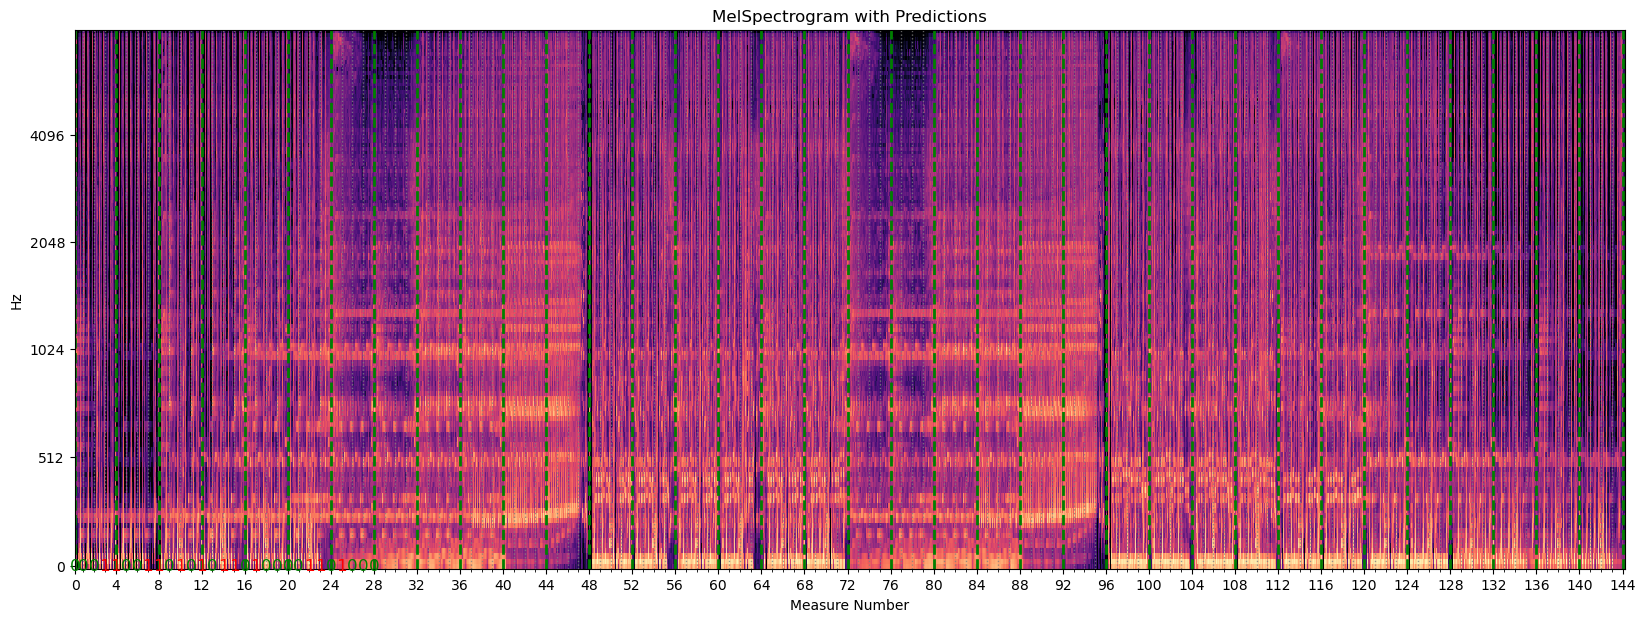

In [113]:
# Function to visualize predictions with color coding
def visualize_predictions_with_colors(melspectrogram, predictions, actual_labels, measure_grid, sr):
    fig, ax = plt.subplots(figsize=(20, 7))

    # Display the melspectrogram
    librosa.display.specshow(melspectrogram, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)

    # Overlay predictions
    for i, (prediction, actual_label) in enumerate(zip(predictions, actual_labels)):
        # Extract scalar values for prediction
        pred_label = np.argmax(prediction)  # Assuming prediction is one-hot encoded

        # Determine color based on correctness
        color = 'green' if pred_label == actual_label else 'red'

        # Overlay the prediction on the melspectrogram
        ax.text(measure_grid[i], 0, str(pred_label), color=color, fontsize=12, ha='center', va='center')

    # Apply measure grid
    apply_measure_grid(ax, measure_grid)

    ax.set_title('MelSpectrogram with Predictions')
    plt.show()
    
# Compute Melspectrogram
D = np.abs(librosa.stft(audio))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Obtain predictions from the trained model
predictions = model.predict(X_test)

# For classification tasks with softmax activation, 'predictions' will contain probability scores for each class.
# If you want to obtain the predicted class labels, you can use np.argmax to get the index of the maximum probability score.
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = measure_segments['label']
# Convert actual_labels to numpy array if necessary
actual_labels = np.array(actual_labels)

# Visualize predictions with color coding
visualize_predictions_with_colors(S_dB, predictions, actual_labels, measure_grid, sr)

In [115]:
len(predicted_labels)

29

In [ ]:
def visualize_predictions(melspectrogram, predictions, measure_grid, sr):
    fig, ax = plt.subplots(figsize=(20, 7))

    # Display the melspectrogram
    librosa.display.specshow(melspectrogram, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)

    # Apply measure grid
    apply_measure_grid(ax, measure_grid)

    # Overlay predictions
    for i, prediction in enumerate(predictions):
        ax.text(measure_grid[i], 0, str(prediction), color='red', fontsize=12, ha='center', va='center')

    ax.set_title('MelSpectrogram with Predictions')
    plt.show()

Text(0.5, 1.0, 'MelSpectrogram')

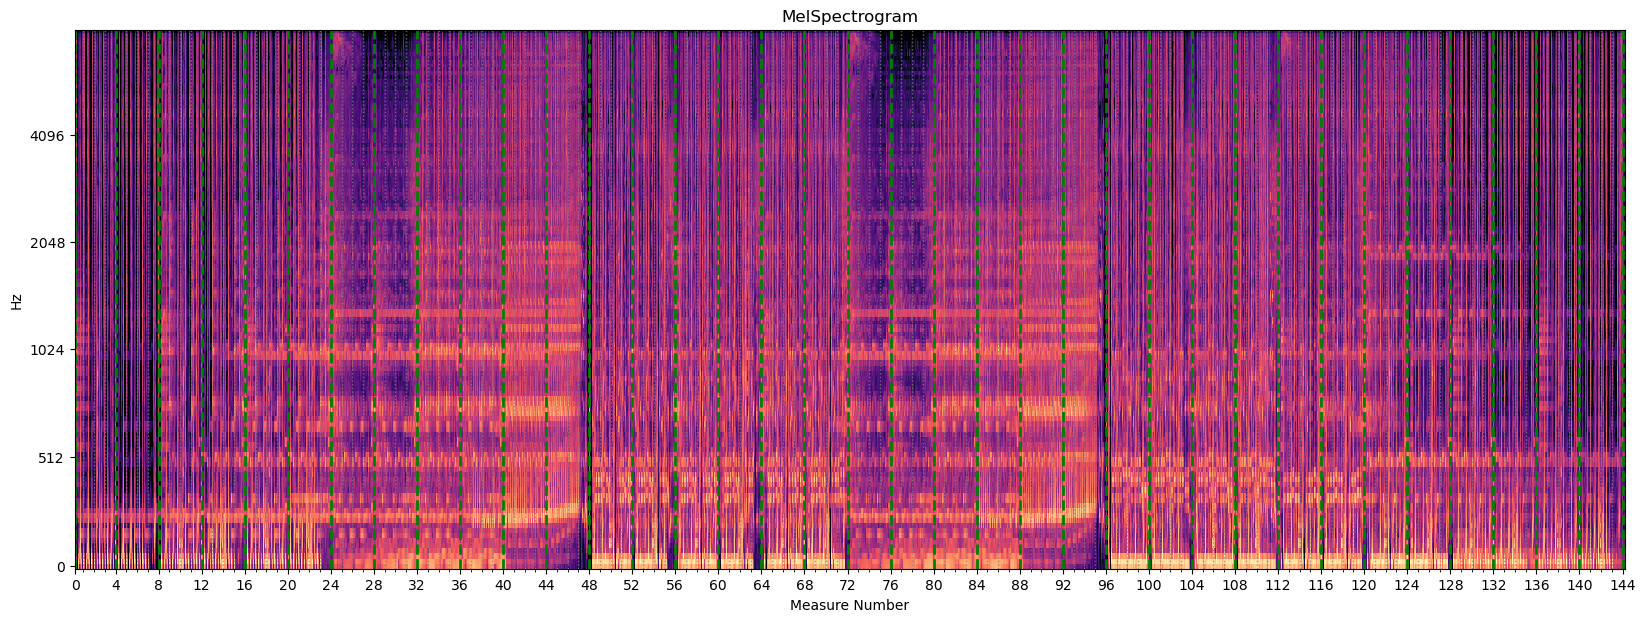

In [24]:
# Compute Melspectrogram
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
apply_measure_grid(ax, measure_grid)
ax.set_title('MelSpectrogram')

# Preprocessing data for CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = (128, 128, 1)  # n_mels is 128 as set in the preprocessing

# Number of classes
num_classes = 2

# Build the CNN
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolutional layer 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Dense layer 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Model summary
model.summary()
